In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Capstone-Dataset')
root_path = '/content/gdrive/My Drive/Capstone-Dataset/'

Mounted at /content/gdrive


In [ ]:
train_dir = os.path.join(root_path, 'train')
validation_dir = os.path.join(root_path, 'validation')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    shuffle=True,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                               shuffle=True,
                                                               batch_size=20,
                                                               color_mode='rgb',
                                                               class_mode  = 'categorical',
                                                               target_size = (150, 150))

Found 2115 images belonging to 7 classes.
Found 208 images belonging to 7 classes.


In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-27 02:20:24--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.18.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  41.0MB/s    in 2.0s    

2022-05-27 02:20:26 (41.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(7, activation='softmax')(x)       

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer = 'adam', 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,518,631 total parameters in this model.
There are 38,543,367 trainable parameters in this model.


In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 2,
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    validation_steps = validation_generator.samples // validation_generator.batch_size)

Epoch 1/50
105/105 - 1167s - loss: 2.2407 - accuracy: 0.4220 - val_loss: 1.1654 - val_accuracy: 0.5900 - 1167s/epoch - 11s/step
Epoch 2/50
105/105 - 124s - loss: 1.2600 - accuracy: 0.5246 - val_loss: 1.0144 - val_accuracy: 0.6200 - 124s/epoch - 1s/step
Epoch 3/50
105/105 - 125s - loss: 1.1559 - accuracy: 0.5690 - val_loss: 1.0260 - val_accuracy: 0.6350 - 125s/epoch - 1s/step
Epoch 4/50
105/105 - 123s - loss: 1.1444 - accuracy: 0.5709 - val_loss: 0.9104 - val_accuracy: 0.7000 - 123s/epoch - 1s/step
Epoch 5/50
105/105 - 120s - loss: 1.0540 - accuracy: 0.6076 - val_loss: 0.9032 - val_accuracy: 0.7100 - 120s/epoch - 1s/step
Epoch 6/50
105/105 - 121s - loss: 1.0496 - accuracy: 0.6019 - val_loss: 0.9027 - val_accuracy: 0.6800 - 121s/epoch - 1s/step
Epoch 7/50
105/105 - 120s - loss: 1.0129 - accuracy: 0.6267 - val_loss: 0.8612 - val_accuracy: 0.6900 - 120s/epoch - 1s/step
Epoch 8/50
105/105 - 121s - loss: 0.9636 - accuracy: 0.6401 - val_loss: 0.8466 - val_accuracy: 0.7350 - 121s/epoch - 1s/st

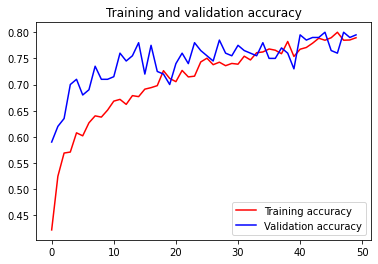

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  root_path = '/content/gdrive/My Drive/Capstone-Dataset/'
  path = root_path + fn
  img = image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0][0] > (classes[0][1] and classes[0][2] and classes[0][3] and classes[0][4] and classes[0][5] and classes[0][6]) :
    print(fn + " is alopecia_areata")
  elif classes[0][1] > (classes[0][0] and classes[0][2] and classes[0][3] and classes[0][4] and classes[0][5] and classes[0][6]) :
    print(fn + " is dandruff")
  elif classes[0][2] > (classes[0][1] and classes[0][0] and classes[0][3] and classes[0][4] and classes[0][5] and classes[0][6]):
    print(fn + " is folliculitis")
  elif classes[0][3] > (classes[0][1] and classes[0][2] and classes[0][0] and classes[0][4] and classes[0][5] and classes[0][6]):
    print(fn + " is healthy_scalp")
  elif classes[0][4] > (classes[0][1] and classes[0][2] and classes[0][3] and classes[0][0] and classes[0][5] and classes[0][6]):
    print(fn + " is psoriasis")
  elif classes[0][5] > (classes[0][1] and classes[0][2] and classes[0][3] and classes[0][4] and classes[0][0] and classes[0][6]):
    print(fn + " is seborrheic_dermatitis")
  elif classes[0][6] > (classes[0][1] and classes[0][2] and classes[0][3] and classes[0][4] and classes[0][5] and classes[0][0]):
    print(fn + " is tinea_capitis")

Saving alo.jpg to alo (2).jpg
Saving alo2.jpg to alo2 (2).jpg
Saving dand.jpg to dand (3).jpg
Saving healthy1.jpg to healthy1 (2).jpg
Saving pso1.jpg to pso1 (3).jpg
Saving sebo1.jpg to sebo1 (3).jpg
Saving tinea.jpg to tinea (3).jpg
[2.5243154e-01 8.7725924e-09 6.5520253e-06 2.8489441e-10 6.7723462e-08
 5.2726716e-07 7.4756128e-01]
alo.jpg is tinea_capitis
[9.5972812e-01 1.0831106e-09 4.9440288e-08 3.3660183e-10 5.1878213e-09
 6.5573205e-09 4.0271953e-02]
alo2.jpg is alopecia_areata
[3.9096067e-06 8.9265704e-01 1.1264348e-08 1.0731398e-01 1.6126181e-07
 9.3995887e-09 2.4847144e-05]
dand.jpg is dandruff
[4.3406446e-05 6.7290998e-01 4.2438614e-08 3.2701445e-01 1.0135976e-06
 2.5008356e-08 3.1069212e-05]
healthy1.jpg is alopecia_areata
[9.9610514e-04 1.1498448e-04 1.8199271e-02 1.0601259e-05 8.4501886e-01
 1.3372773e-01 1.9324208e-03]
pso1.jpg is folliculitis
[6.4313492e-05 1.5563362e-02 6.3919961e-01 1.8179325e-04 8.1071161e-02
 2.5863624e-01 5.2835299e-03]
sebo1.jpg is dandruff
[4.4839

In [ ]:
model.save(root_path + "/model/{}".format('Categorical-adam_default-Capstone-Project-C22PS22'))

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone-Dataset//model/Categorical-adam_default-Capstone-Project-C22PS22/assets


In [ ]:
import pathlib

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/1/assets


47763056

In [ ]:
saved_model_path = "./my_model.h5"

!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 40 kB 3.8 MB/s 
     |████████████████████████████████| 462 kB 37.0 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 813, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 817, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 804, in convert
    weight_shard_size_bytes, metadata_map)
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 501, in _dispatch_converter
    metadata=metadata_map)
  File "/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/converter.py", line 76, in dispatch_keras_h5_to_tfjs_layers_model_conversion
    raise ValueError('Nonexistent path to HDF5 file: %s' % h5_path)
ValueError: Nonexistent path to HDF5 file: ./my_model.h5


In [ ]:
model.save('Categorical_Adam.h5')